## States
- **RED (Stop)**: Recovery phase where arousal decreases, allowing the viewer to rest before resuming stimulation.
- **GREEN (Go)**: Build-up phase where arousal gradually increases, preparing the viewer for higher levels of stimulation.
- **YELLOW (Get to Edge)**: Intense build-up phase that pushes arousal to the edge, preparing the viewer to stay in a highly aroused state.
- **PURPLE (Stay at Edge)**: Peak phase where arousal reaches maximum levels, requiring control to avoid climax and maintain the edge.
- **PINK (Release/End)**: Final state that represents the climax or release, signaling the end of the session.

## State Transitions
- **RED → GREEN**: After a period of recovery, transition to 'GREEN' to begin arousal build-up.
- **GREEN → YELLOW**: When 'Arousal' reaches the current 'Tolerance' level (representing the threshold to reach the edge), transition to 'YELLOW' for intense build-up.
- **YELLOW → PURPLE**: After reaching the edge, transition to 'PURPLE' to hold maximum arousal and stay at the edge.
- **PURPLE → RED**: After maintaining the edge for a specified duration, return to 'RED' for recovery.
- **GREEN → RED**: A random chance allows an unexpected cooldown, returning to 'RED' for brief recovery even if arousal is high.
- **YELLOW_FINAL → PURPLE_FINAL → PINK**: After reaching the climax condition, transition through 'YELLOW_FINAL' and 'PURPLE_FINAL' for the final buildup, ending in 'PINK' (release).

## Internal Variables
1. **Arousal (Pleasure Intensity)**:
   - Represents the viewer's level of stimulation and excitement.
   - Increases during 'GREEN', 'YELLOW', and 'PURPLE' states, with the fastest increase in 'PURPLE' (Stay at Edge).
   - Decreases during 'RED' (Stop) to simulate a cooldown period.
   - Arousal is clamped at 100% during 'PURPLE' to represent the viewer being at the edge of climax.
   - When Arousal reaches the current 'Tolerance' level, the viewer transitions from 'GREEN' to 'YELLOW', signaling the approach to the edge.

2. **Tolerance**:
   - Represents the threshold for climax resistance, increasing the longer the viewer stays in high-arousal states.
   - Starts at 0 and gradually increases in 'YELLOW' and 'PURPLE', allowing the viewer to reach higher arousal levels without climaxing.
   - Higher Tolerance makes it progressively harder to climax, simulating increased control over arousal.
   - In 'YELLOW' and 'PURPLE' states, Tolerance increases, which raises the level of arousal required to transition to the climax state.
   - Maximum Tolerance is capped at 100% to set a limit on the viewer's resistance to climax.
   
3. **Effective Arousal Threshold** (Virtual Line):
   - This is a calculated threshold based on the current Tolerance level.
   - Represents the "achievable arousal" level for the viewer, which needs to be met to trigger certain transitions, such as from 'GREEN' to 'YELLOW'.
   - This line moves higher as Tolerance increases, allowing the viewer to maintain control over higher levels of arousal without reaching climax.

## Summary of Dynamics
- **Arousal** rises in response to 'GREEN', 'YELLOW', and 'PURPLE', with the goal of reaching the current Tolerance level.
- **Tolerance** rises with time spent in 'YELLOW' and 'PURPLE', setting a moving target for Arousal to overcome.
- **Effective Arousal Threshold** (based on Tolerance) creates a dynamic climax threshold, challenging the viewer to resist climaxing at increasingly higher arousal levels.
- Random transitions from **'GREEN' to 'RED'** add variability, preventing predictable cycles and simulating unexpected cooldowns.


Additional Possible Mechanisms
| Variable               | Transition Influence                                       | Benefit                                                          |
|------------------------|------------------------------------------------------------|------------------------------------------------------------------|
| **Arousal**            | Momentum affects transition speed                          | Simulates escalation to edge                                     |
| **Fatigue**            | Slows arousal, faster **RED** transitions                  | Creates natural recovery cycles                                  |
| **Focus Intensity**    | Lowers edge thresholds for **YELLOW**                      | Increases realism for high-focus scenarios                       |
| **Desire**             | Scales **GREEN** and **PURPLE** durations                  | Provides emotional depth to session pacing                       |
| **Resilience**         | Slower **RED** transitions with high resilience            | Models tolerance for prolonged **PURPLE**                        |
| **Anticipation**       | Exponential increase for **YELLOW**/**PURPLE** transitions | Sudden, exciting transitions                                     |
| **Threshold Saturation** | Slows decay rates near max tolerance                     | Enhances prolonged engagement at higher tolerance levels         |
| **Confidence**         | Faster cycle times with high confidence                    | Personalizes experience based on user familiarity                |


In [25]:
#todo:
"""
make the static purples smarter, basically anticipate one state before so that you can expand a green or red just before, just so you dont do a purple right before the scheduled purple
allow adding static greens and reds
make next_state fully naive. right now it's being sent state information it arguably shouldn't have, like total edges and max duration
make greens longer the longer the session goes
make reds shorter the longer the session goes
figure out if you want to keep arousal
figure out if fatigue and anticipation modeling makes sense

"""
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

# Function to get random duration for a state
def get_random_duration(state, arousal, tolerance, STATE_DURATIONS):
    min_duration, max_duration = STATE_DURATIONS[state]
    if state in ['PURPLE', 'PURPLE_FINAL']:
        # Higher tolerance increases duration in 'PURPLE'
        tolerance_factor = max(min(tolerance / 100, 1.0), 0)
        duration = random.uniform(min_duration, max_duration) * (0.5 + 0.5 * tolerance_factor)
    elif state in ['YELLOW', 'YELLOW_FINAL']:
        # Higher tolerance reduces duration in 'YELLOW'
        tolerance_factor = max(min(tolerance / 100, 1.0), 0)
        duration = random.uniform(min_duration, max_duration) * (0.5 + 0.5 * (1 - tolerance_factor))
    else:
        duration = random.uniform(min_duration, max_duration)
    return duration

# Function to determine the next state and update variables
def next_state(current_state, arousal, tolerance, current_state_duration, time_elapsed, edge_count, params):
    # Unpack parameters
    GREEN_EDGE_CHANCE_START = params['GREEN_EDGE_CHANCE_START']
    GREEN_EDGE_CHANCE_END = params['GREEN_EDGE_CHANCE_END']
    RED_EDGE_CHANCE_START = params['RED_EDGE_CHANCE_START']
    RED_EDGE_CHANCE_END = params['RED_EDGE_CHANCE_END']
    MIN_TIME_BEFORE_EDGE = params['MIN_TIME_BEFORE_EDGE']

    AROUSAL_DECAY_RATE = params['AROUSAL_DECAY_RATE']
    TOLERANCE_DECAY_RATE = params['TOLERANCE_DECAY_RATE']

    STATE_RATES = params['STATE_RATES']
    scheduled_purple_times = params.get('scheduled_purple_times', [])

    next_state = None

    # Check for scheduled 'PURPLE' state
    if scheduled_purple_times and time_elapsed >= scheduled_purple_times[0]:
        if current_state not in ['PURPLE', 'YELLOW']:
            scheduled_purple_times.pop(0)
            next_state = 'YELLOW'
    else:
        # State Transitions
        if current_state == 'RED':
            edge_chance = RED_EDGE_CHANCE_START + (RED_EDGE_CHANCE_END - RED_EDGE_CHANCE_START) * (tolerance / 100)
            if time_elapsed >= params['MAX_DURATION']:
                next_state = 'YELLOW_FINAL'
            elif time_elapsed <= MIN_TIME_BEFORE_EDGE:
                next_state = 'GREEN'
            elif random.random() < edge_chance / 100:
                next_state = 'YELLOW'
            else:
                next_state = 'GREEN'
        elif current_state == 'GREEN':
            edge_chance = GREEN_EDGE_CHANCE_START + (GREEN_EDGE_CHANCE_END - GREEN_EDGE_CHANCE_START) * (tolerance / 100)
            if time_elapsed >= params['MAX_DURATION']:
                print('duration finished')
                next_state = 'YELLOW_FINAL'
            elif time_elapsed <= MIN_TIME_BEFORE_EDGE:
                next_state = 'RED'
            elif random.random() < edge_chance / 100:
                next_state = 'YELLOW'
            else:
                next_state = 'RED'
        elif current_state == 'YELLOW':
            if time_elapsed >= params['MAX_DURATION']:
                next_state = 'PURPLE_FINAL'
            else:
                next_state = 'PURPLE'
        elif current_state == 'PURPLE':
            edge_count += 1
            if edge_count >= params['MAX_EDGES']:
                next_state = 'PURPLE_FINAL'
            elif time_elapsed >= params['MAX_DURATION']:
                next_state = 'PINK'
            else:
                next_state = 'RED'
        elif current_state == 'YELLOW_FINAL':
            next_state = 'PURPLE_FINAL'
        elif current_state == 'PURPLE_FINAL':
            next_state = 'PINK'
        elif current_state == 'PINK':
            return None, arousal, tolerance, edge_count
    
    # Update Arousal and Tolerance based on current state
    rates = STATE_RATES[current_state]
    arousal_rate = rates['arousal_rate']
    arousal_static = rates['arousal_static']
    tolerance_rate = rates['tolerance_rate']
    tolerance_static = rates['tolerance_static']

    arousal = min(max(arousal + arousal_rate * current_state_duration + arousal_static, 0), 100)
    tolerance = min(max(tolerance + tolerance_rate * current_state_duration + tolerance_static, 0), 100)

    # Update decay rates
    arousal = min(max(arousal - AROUSAL_DECAY_RATE * current_state_duration, 0), 100)
    tolerance = min(max(tolerance - TOLERANCE_DECAY_RATE * current_state_duration, 0), 100)

    return next_state, arousal, tolerance, edge_count

# Function to simulate a single session
def simulate_session(params):
    # Unpack parameters
    MIN_DURATION = params['MIN_DURATION']
    MAX_DURATION = params['MAX_DURATION']
    MIN_EDGES = params['MIN_EDGES']
    MAX_EDGES = params['MAX_EDGES']
  
    STATE_DURATIONS = params['STATE_DURATIONS']

    # Scheduled 'PURPLE' times (if any)
    scheduled_purple_times = params.get('scheduled_purple_times', [])
    scheduled_purple_times.sort()

    # Initialize variables
    current_state = 'RED'
    timeline = []
    emotions = []
    time_elapsed = 0

    arousal = 0.0  # Initial arousal
    tolerance = 0.0  # Initial tolerance
    purple_count = 0  # Count of PURPLE sections

    while current_state is not None:
        # Set the duration of the current state
        duration = get_random_duration(current_state, arousal, tolerance, STATE_DURATIONS)

        # Append to timeline and emotions before updating arousal and tolerance
        timeline.append({'state': current_state, 'start_time': time_elapsed, 'duration': duration})
        emotions.append({'time': time_elapsed, 'Arousal': arousal, 'Tolerance': tolerance})

        # Update time elapsed
        time_elapsed += duration

        # Get next state and updated variables
        next_state_name, arousal, tolerance, purple_count = next_state(
            current_state, arousal, tolerance, duration, time_elapsed, purple_count, params
        )

        # Exit conditions
        is_finishing_state = next_state_name in ['YELLOW_FINAL', 'PURPLE_FINAL', 'PINK', None]
        if not is_finishing_state: # force into final state if external conditions are met 
            if purple_count >= MAX_EDGES:
                current_state = 'YELLOW_FINAL'
            elif time_elapsed >= MAX_DURATION:
                current_state = 'YELLOW_FINAL'
            elif tolerance >= 100:
                current_state = 'YELLOW_FINAL'
            else: 
                current_state = next_state_name
        else:
            current_state = next_state_name

        # Break if the session is over
        if current_state == 'PINK':
            break

    return timeline, emotions

# Function to run multiple simulations
def run_simulations(num_simulations, params):
    simulation_results = []
    for _ in range(num_simulations):
        timeline, emotions = simulate_session(params)
        # Collect statistics
        total_duration = timeline[-1]['start_time'] + timeline[-1]['duration']
        purple_sections = [seg for seg in timeline if seg['state'] in ['PURPLE', 'PURPLE_FINAL']]
        num_purple = len(purple_sections)
        total_purple_duration = sum(seg['duration'] for seg in purple_sections)
        simulation_results.append({
            'timeline': timeline,
            'emotions': emotions,
            'total_duration': total_duration,
            'num_purple': num_purple,
            'total_purple_duration': total_purple_duration
        })
    return simulation_results



Average number of PURPLE sections: 9.4
Average total duration: 2745.38 seconds
Average total PURPLE duration: 214.44 seconds
Minimum total duration: 2274.49 seconds
Maximum total duration: 3224.37 seconds


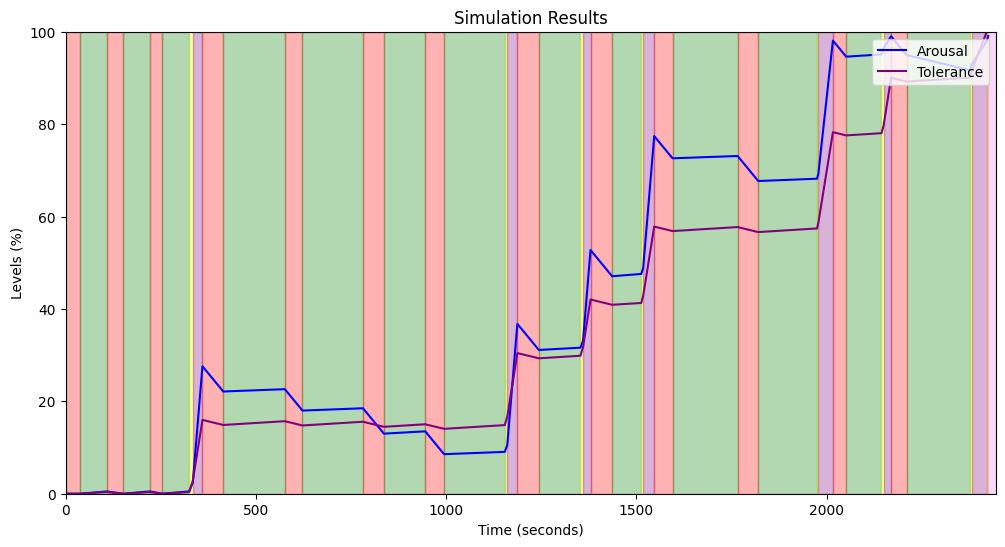

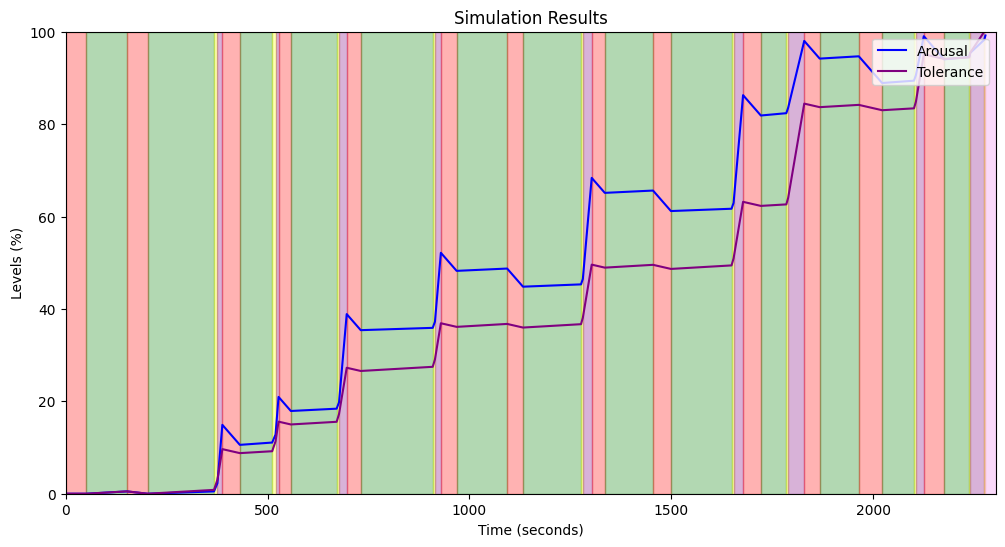

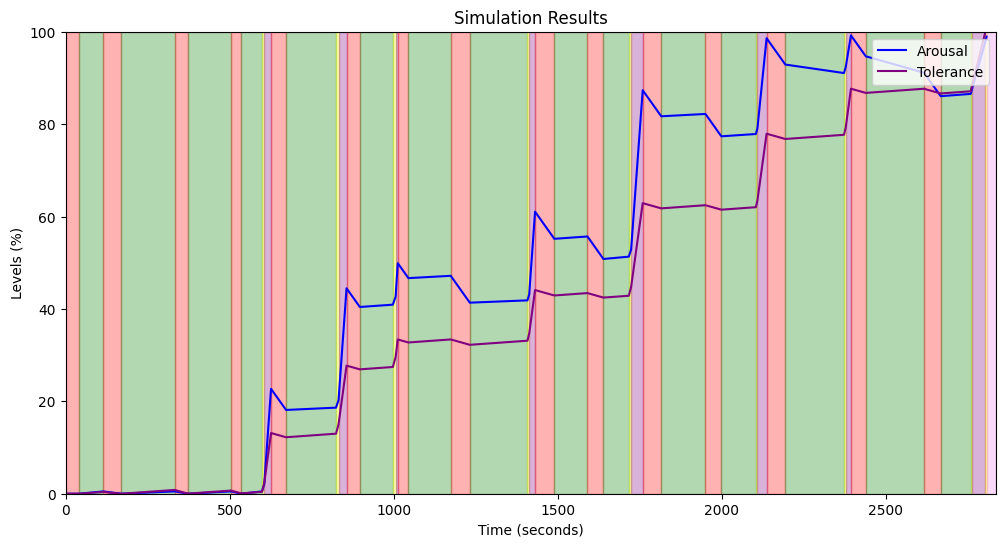

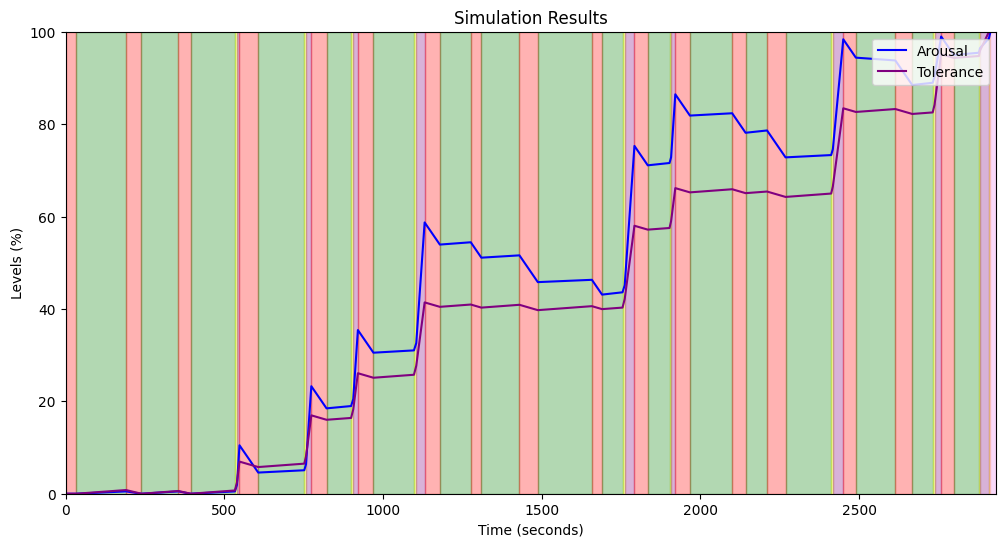

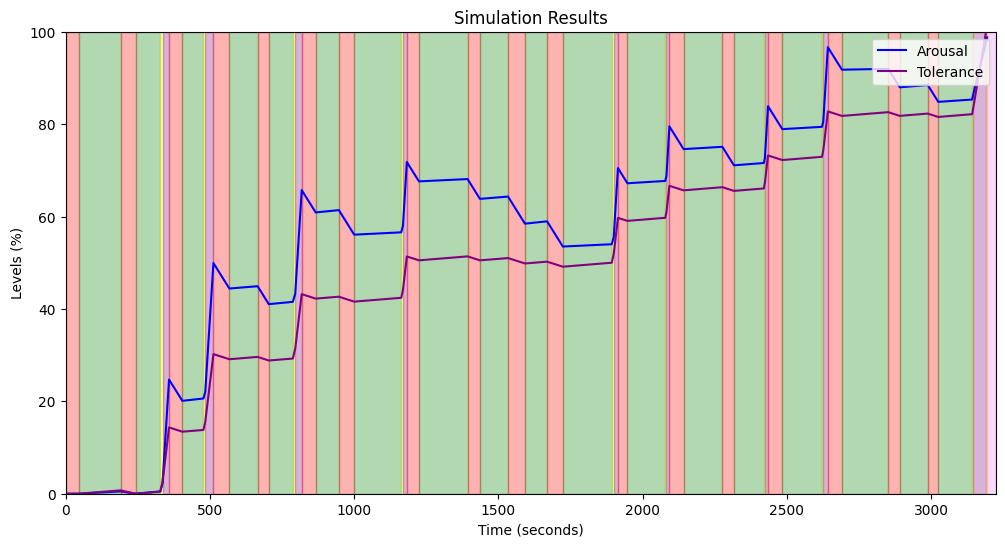

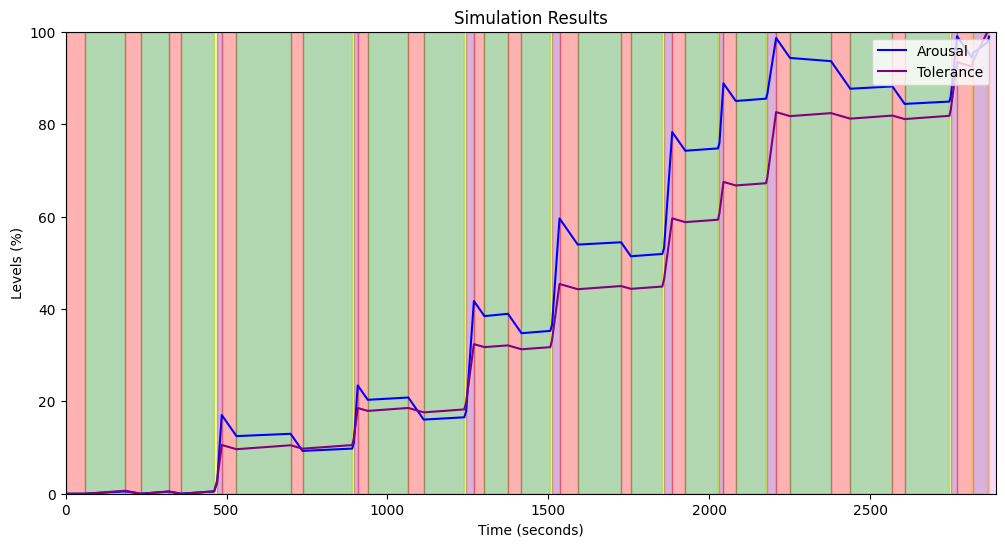

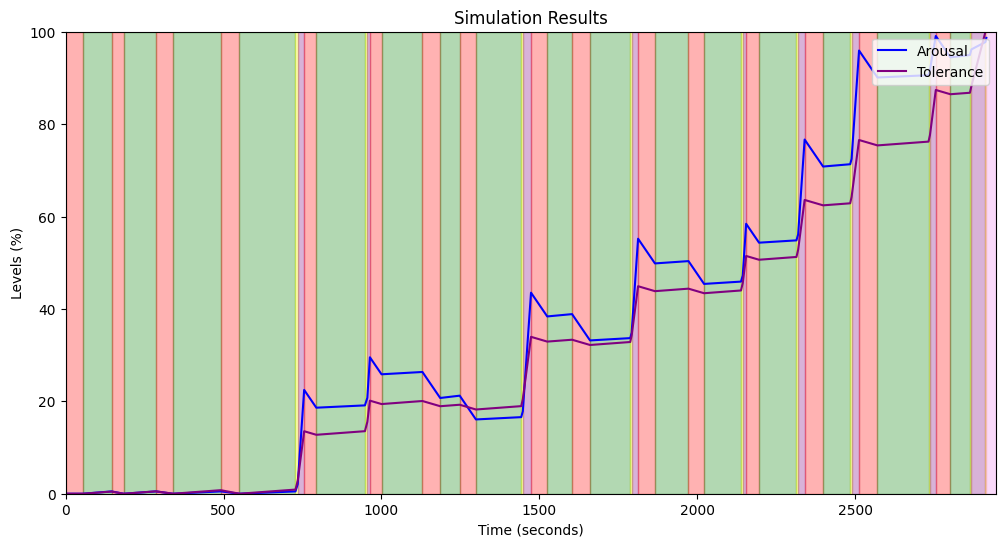

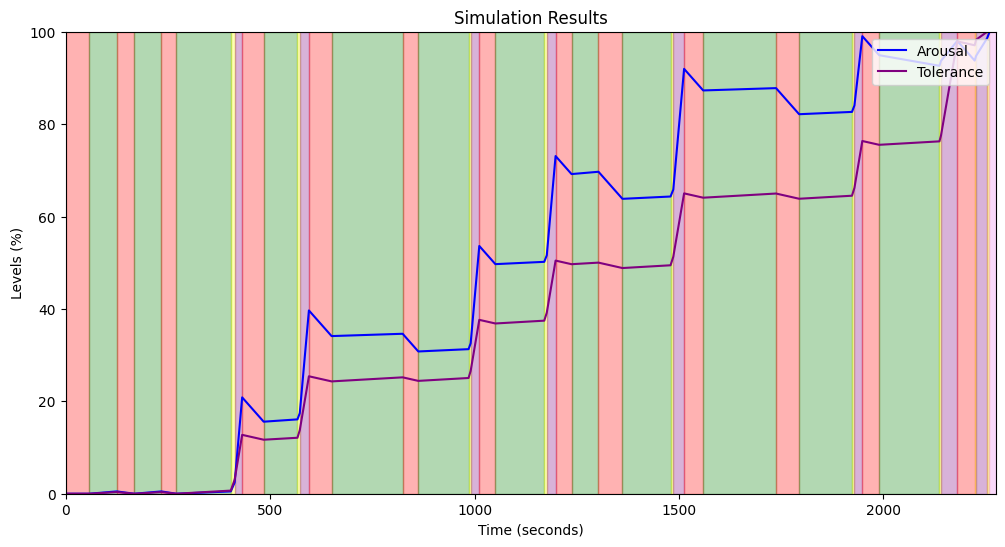

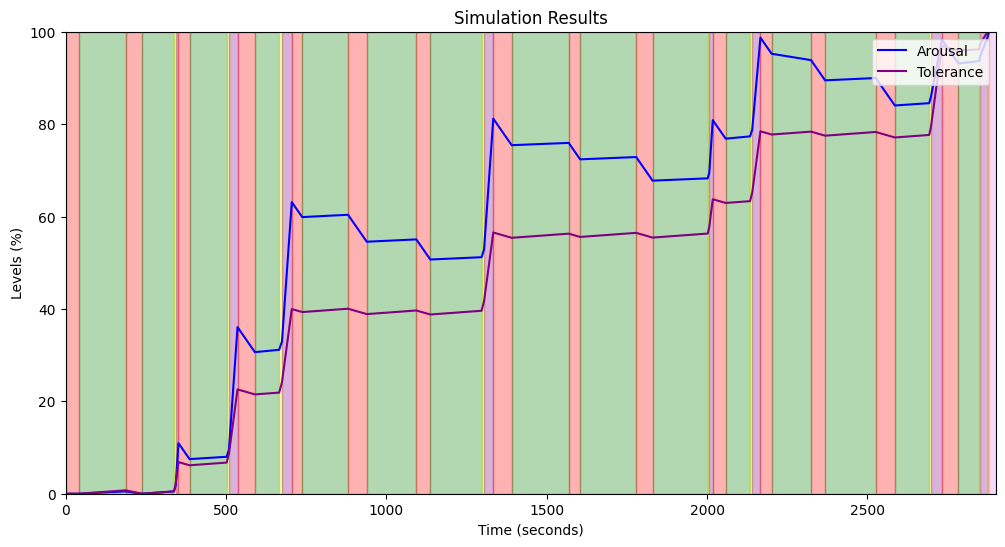

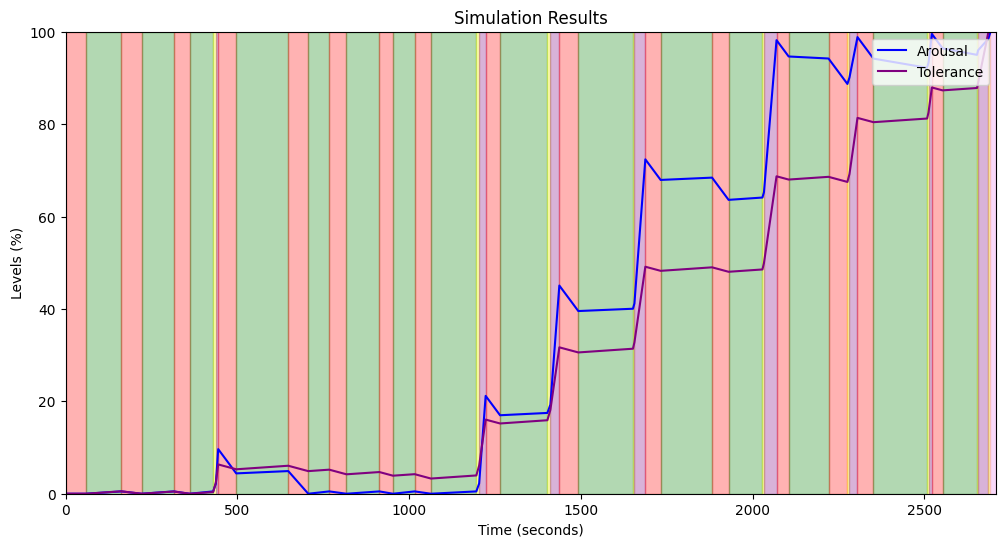

In [30]:
# Example usage
params = {
    'MIN_DURATION': 1000,
    'MAX_DURATION': 4000,
    'MIN_EDGES': 1,
    'MAX_EDGES': 30,
    'GREEN_EDGE_CHANCE_START': 50,    # % chance for GREEN -> YELLOW when tolerance is 0
    'GREEN_EDGE_CHANCE_END': 80,      # % chance for GREEN -> YELLOW when tolerance is 100
    'RED_EDGE_CHANCE_START': -50,     # % chance for RED -> YELLOW when tolerance is 0
    'RED_EDGE_CHANCE_END': 30,        # % chance for RED -> YELLOW when tolerance is 100
    'MIN_TIME_BEFORE_EDGE': 300,
    'AROUSAL_DECAY_RATE': 0.05,
    'TOLERANCE_DECAY_RATE': 0,
    'STATE_RATES': {
        'RED': {'arousal_rate': -0.05, 'arousal_static': 0, 'tolerance_rate': -0.02, 'tolerance_static': -0.0},
        'GREEN': {'arousal_rate': 0.05, 'arousal_static': 0.5, 'tolerance_rate': 0.005, 'tolerance_static': 0.01},
        'YELLOW': {'arousal_rate': 0.2, 'arousal_static': 0.5, 'tolerance_rate': 0.2, 'tolerance_static': 0.5},
        'PURPLE': {'arousal_rate': 1.0, 'arousal_static': 1.0, 'tolerance_rate': 0.5, 'tolerance_static': 0.5},
        'YELLOW_FINAL': {'arousal_rate': 0.2, 'arousal_static': 0.5, 'tolerance_rate': 0.2, 'tolerance_static': 0.5},
        'PURPLE_FINAL': {'arousal_rate': 1.0, 'arousal_static': 1.0, 'tolerance_rate': 0.5, 'tolerance_static': 0.5},
        'PINK': {'arousal_rate': 0, 'arousal_static': 0, 'tolerance_rate': 0, 'tolerance_static': 0},
    },
    'STATE_DURATIONS': {
        'RED': (20, 90),
        'GREEN': (60, 300),
        'YELLOW': (8, 10),
        'PURPLE': (5, 50),
        'YELLOW_FINAL': (5, 10),
        'PURPLE_FINAL': (15, 30),
        'PINK': (5, 5)  # Fixed duration
    },
    # Optional scheduled PURPLE times
    # 'scheduled_purple_times': [600, 1200, 1800, 2400, 3000]
}

# Run simulations
num_simulations = 10
simulation_results = run_simulations(num_simulations, params)

# Analyze results
average_purple_count = sum(result['num_purple'] for result in simulation_results) / num_simulations
average_total_duration = sum(result['total_duration'] for result in simulation_results) / num_simulations
average_purple_duration = sum(result['total_purple_duration'] for result in simulation_results) / num_simulations

print(f"Average number of PURPLE sections: {average_purple_count}")
print(f"Average total duration: {average_total_duration:.2f} seconds")
print(f"Average total PURPLE duration: {average_purple_duration:.2f} seconds")
print(f"Minimum total duration: {min(result['total_duration'] for result in simulation_results):.2f} seconds")
print(f"Maximum total duration: {max(result['total_duration'] for result in simulation_results):.2f} seconds")

# Visualization of one simulation
for i in range(len(simulation_results)):
    timeline = simulation_results[i]['timeline']
    emotions = simulation_results[i]['emotions']
    time_elapsed = simulation_results[i]['total_duration']

    # Define color mapping for states
    color_map = {
        'RED': 'red',
        'GREEN': 'green',
        'YELLOW': 'yellow',
        'PURPLE': 'purple',
        'YELLOW_FINAL': 'gold',
        'PURPLE_FINAL': 'violet',
        'PINK': 'pink'
    }

    # Define times based on emotions' recorded times
    times = [e['time'] for e in emotions]

    # Visualization of the timeline and internal variables
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the state timeline as background color bars
    for segment in timeline:
        color = color_map.get(segment['state'], 'gray')
        start = segment['start_time']
        duration = segment['duration']
        ax1.add_patch(mpatches.Rectangle((start, 0), duration, 100, color=color, alpha=0.3))

    # Plot the internal variable levels on top of the timeline
    ax1.plot(times, [e['Arousal'] for e in emotions], label='Arousal', color='blue', linewidth=1.5)
    ax1.plot(times, [e['Tolerance'] for e in emotions], label='Tolerance', color='purple', linewidth=1.5)

    # Add labels and legend
    ax1.set_xlim(0, time_elapsed)
    ax1.set_ylim(0, 100)
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Levels (%)")
    ax1.legend(loc="upper right")
    plt.title('Simulation Results')

    plt.show()


In [32]:
simulation_results[-1]

{'timeline': [{'state': 'RED',
   'start_time': 0,
   'duration': 58.752102830964105},
  {'state': 'GREEN',
   'start_time': 58.752102830964105,
   'duration': 103.09425139598531},
  {'state': 'RED',
   'start_time': 161.84635422694942,
   'duration': 58.96779921280512},
  {'state': 'GREEN',
   'start_time': 220.81415343975453,
   'duration': 93.79586258500683},
  {'state': 'RED',
   'start_time': 314.61001602476136,
   'duration': 46.11099706449327},
  {'state': 'GREEN',
   'start_time': 360.72101308925465,
   'duration': 68.6122576086702},
  {'state': 'YELLOW',
   'start_time': 429.33327069792483,
   'duration': 7.924296078376378},
  {'state': 'PURPLE',
   'start_time': 437.2575667763012,
   'duration': 6.802319915315532},
  {'state': 'RED',
   'start_time': 444.0598866916167,
   'duration': 52.48656346650063},
  {'state': 'GREEN',
   'start_time': 496.54645015811735,
   'duration': 151.41019159362207},
  {'state': 'RED',
   'start_time': 647.9566417517394,
   'duration': 58.20124870